# Plot learning curves

In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

In [30]:
# move to root directory
while os.path.basename(os.getcwd()) != "reward-network-iii":
    os.chdir("..")

In [31]:
files = [
    'data/24_02_04/model/mode_nodes_more_steps_0.csv',
    'data/24_02_04/model/mode_nodes_more_steps_1.csv',
    'data/24_02_04/model/mode_nodes_more_steps_2.csv',
]

dfs = []
for s, file in enumerate(files):
    df = pd.read_csv(file)
    df['seed'] = s
    dfs.append(df)
df = pd.concat(dfs)

In [33]:
df[['average reward', 'average level']] = df[['test_avg_reward_all_envs', 'test_avg_level_all_envs']]

df = df[['episode', 'seed', 'average reward', 'average level']]

# total training time is 310 seconds
df['time'] = df['episode'] * 310 / 5000

df = df.dropna()
df['seed'] = df['seed'].astype(str)

In [34]:
# load reference solutions from heuristics

df_myopic = pd.read_json('data/23_11_30/solution_test__myopic.json')
df_random = pd.read_json('data/23_11_30/solution_test__random.json')
df_take_loss = pd.read_json('data/23_11_30/solution_test__take_loss.json')


ref_max_level = {
    'myopic': df_myopic['max_level'].mean(),
    'random': df_random['max_level'].mean(),
    'take_loss': df_take_loss['max_level'].mean(),
}
ref_total_reward = {
    'myopic': df_myopic['total_reward'].mean(),
    'random': df_random['total_reward'].mean(),
    'take_loss': df_take_loss['total_reward'].mean(),
}

In [35]:
# smooth the data group by seed
df = df.groupby('seed').rolling(10, center=True).mean().reset_index()
df = df.dropna()

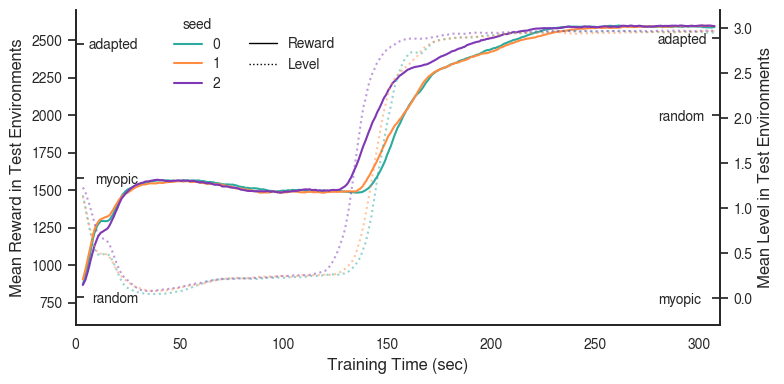

In [38]:


fig, ax1 = plt.subplots(figsize=(8, 4))

sns.set_theme(style='white', rc={'font.family': 'serif', 'font.serif': ['Times New Roman', 'FreeSans']})
custom_palette = ['#2BAA9D', '#FF8C41', '#7F37B6']

lines_info = [
    ('myopic', 'myopic'),
    ('random', 'random'),
    ('take_loss', 'adapted')
]

# Plot for rewards
ax1.set_xlabel('Training Time (sec)', fontsize=12)
ax1.set_ylabel('Mean Reward in Test Environments', fontsize=12)
ax1.set_ylim(600, 2700)
ax1.set_xlim(0, 310)
sns.lineplot(data=df, x="time", y="average reward", hue="seed", palette=custom_palette, ax=ax1, linestyle='-')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=10)
pad_distance = 0
for label in ax1.get_yticklabels():
    label.set_horizontalalignment('right')
    label.set_x(label.get_position()[0] - pad_distance)

# Second y-axis for levels
ax2 = ax1.twinx()
ax2.set_ylabel('Mean Level in Test Environments', fontsize=12)
ax2.set_ylim(-.3, 3.2)
sns.lineplot(data=df, x="time", y="average level", hue="seed", palette=custom_palette, ax=ax2, linestyle=':', legend=None, alpha=0.5)

ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=10)
for label in ax2.get_yticklabels():
    label.set_horizontalalignment('left')
    label.set_x(label.get_position()[0] + pad_distance)

# Adding specific labels as secondary y-axis ticks for rewards
secax1 = ax1.secondary_yaxis('left')
secax1.set_yticks([ref_total_reward[line[0]] for line in lines_info])
secax1.set_yticklabels([line[1] for line in lines_info])
secax1.tick_params(axis='y', direction='in', pad=-45, labelsize=10)

# Adding specific labels as secondary y-axis ticks for levels
secax2 = ax2.secondary_yaxis('right')
secax2.set_yticks([ref_max_level[line[0]] for line in lines_info])
secax2.set_yticklabels([line[1] for line in lines_info])
secax2.tick_params(axis='y', direction='in', pad=-45, labelsize=10)

legend1 = ax1.legend(frameon=True, fontsize=10, title='seed', title_fontsize=10, loc='upper left',
                     bbox_to_anchor=(0.12, 1.04), facecolor='white', borderpad=1, labelspacing=0.4)
legend1.get_frame().set_alpha(1)
legend1.get_frame().set_edgecolor('none')

# Create custom legend for line styles
custom_lines = [Line2D([0], [0], color='black', lw=1, linestyle='-'),
                Line2D([0], [0], color='black', lw=1, linestyle=':')]

line_style_legend = ax1.legend(custom_lines, ['Reward', 'Level'], loc='upper left', bbox_to_anchor=(0.25, 0.955), frameon=False, fontsize=10, title_fontsize=10)

# Add the first legend back to the plot
ax1.add_artist(legend1)

# Create folder and save figures
folder = os.path.join('analysis', 'plots', 'algorithm')
os.makedirs(folder, exist_ok=True)
png_filename = os.path.join(folder, 'algorithm.png')
pdf_filename = os.path.join(folder, 'algorithm.pdf')

plt.tight_layout()
plt.savefig(png_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig(pdf_filename, bbox_inches='tight', pad_inches=0.1)
